## Project Proposal: 

# EVOLUTION of THOUGHTS 
# by DATA and TEXT MINING from SCHOLARLY LITERATURE

![workflow](workflow.png)

## Case Study #1: Exploratory data analysis with query = ‘global warming’

YOUR QUERY:  GLOBAL WARMING

Data mining in progress, acquiring:
                                   10000 of 10000 most relevant articles ...

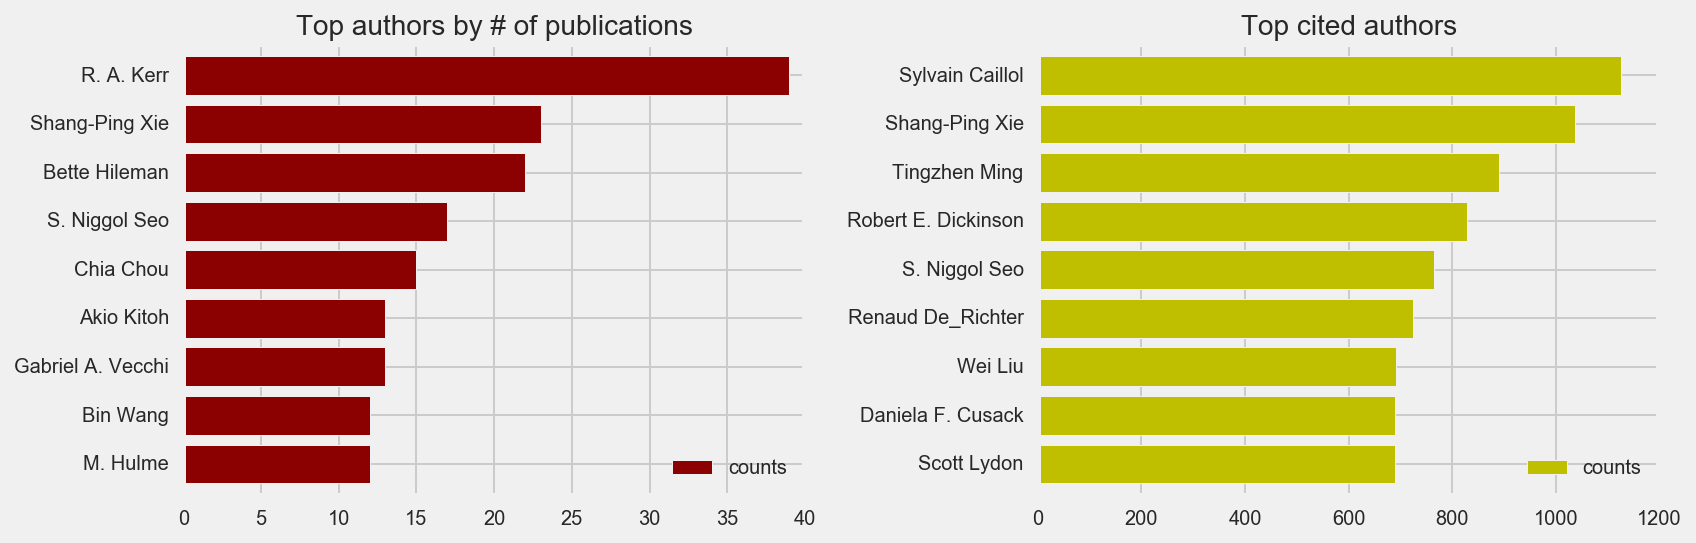

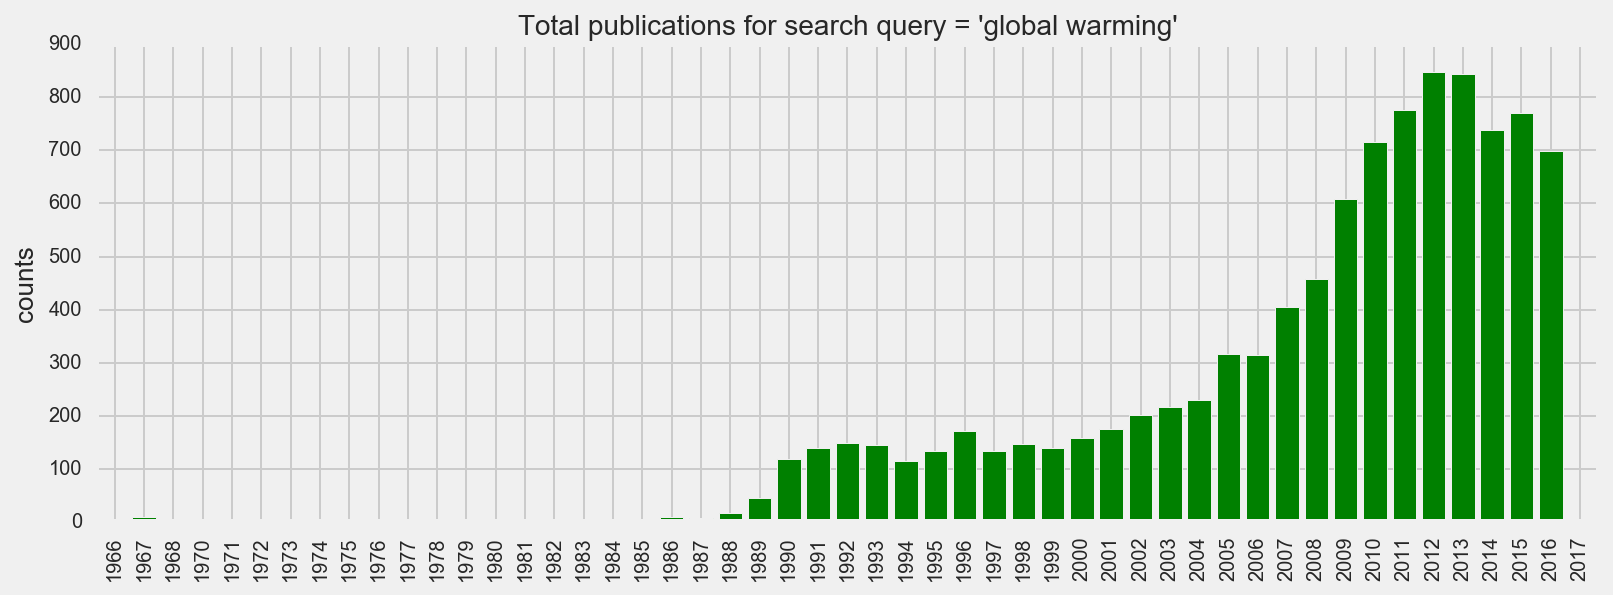

 
Running 50000 MCMC steps to estimate the expected number of publications per year
 [-----------------100%-----------------] 50000 of 50000 complete in 17.2 sec

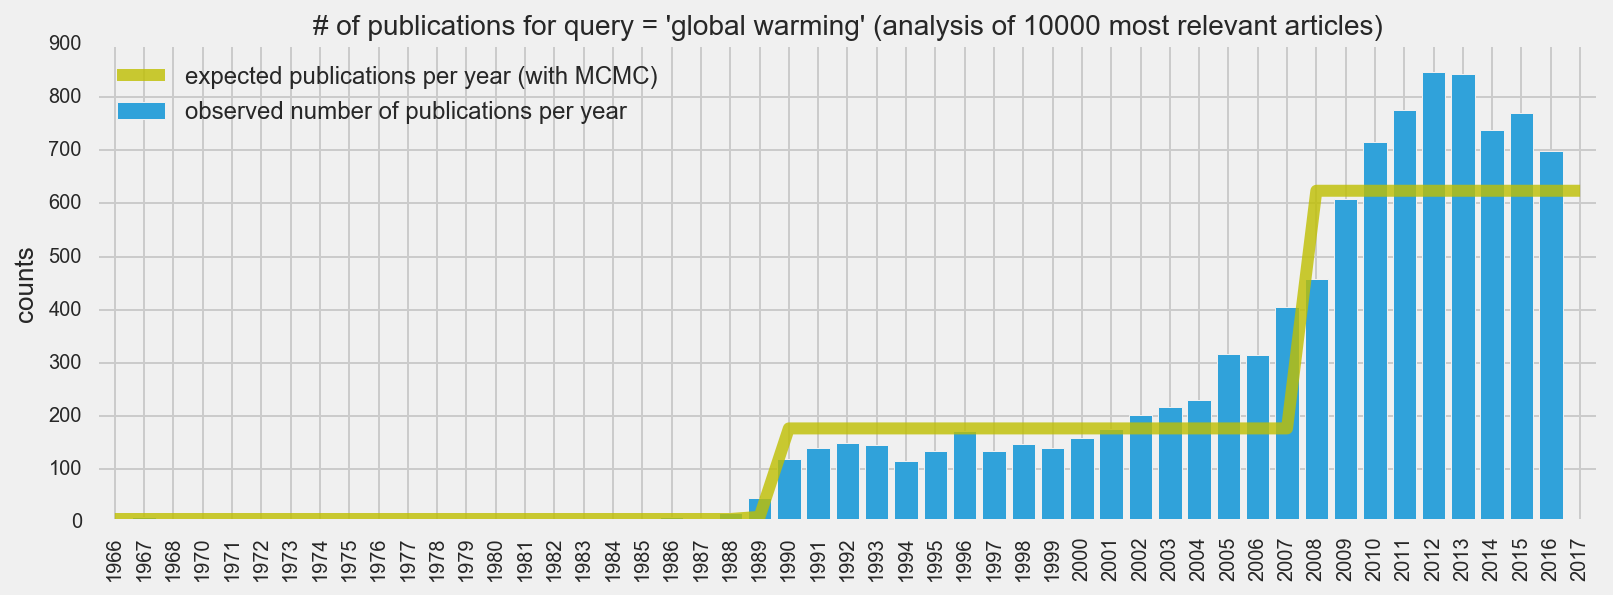


PRELIMINARY ANALYSIS of TEXT


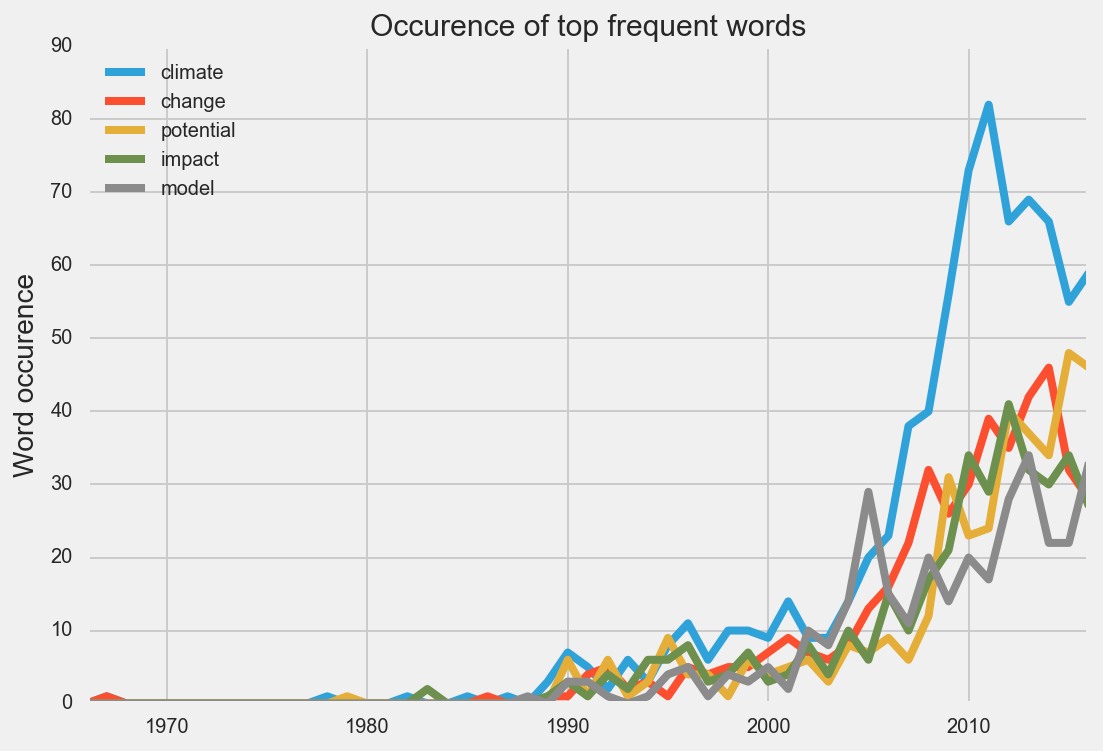


WORD CLOUD FOR YEARS BETWEEN 1966 and 1976


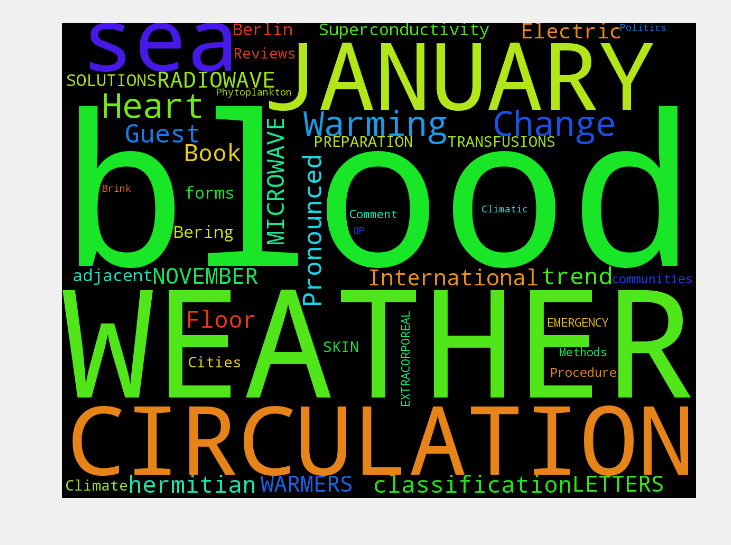


WORD CLOUD FOR YEARS BETWEEN 2006 and 2016


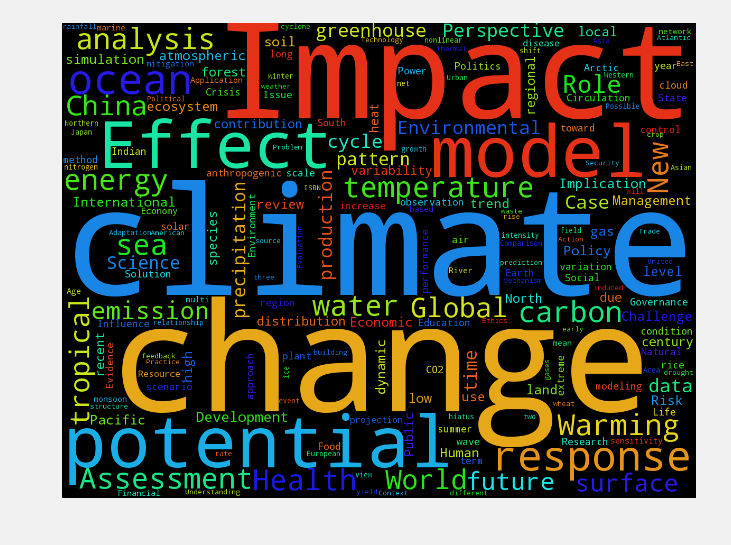

In [26]:
if __name__ == "__main__":
    df, text = main(query='global warming')

## Case Study #2: Exploratory data analysis with query = ‘neural networks’

YOUR QUERY:  NEURAL NETWORKS

Data mining in progress, acquiring:
                                   10000 of 10000 most relevant articles ...

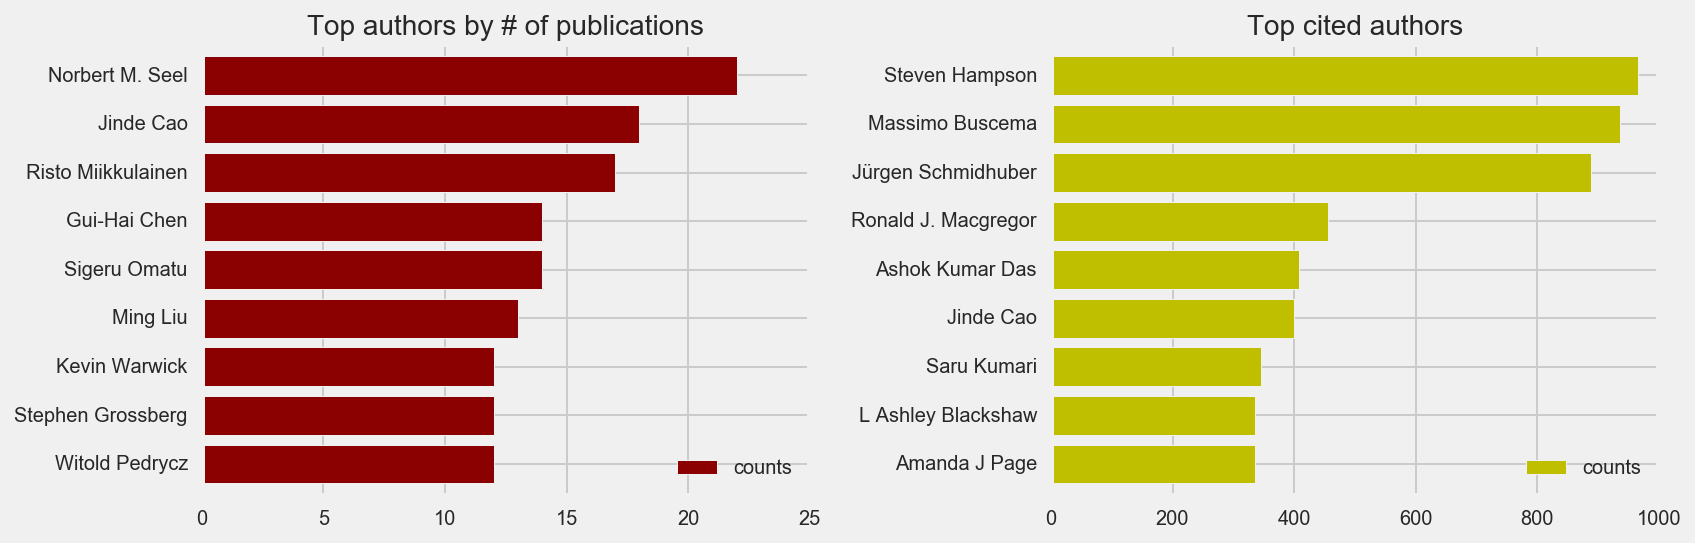

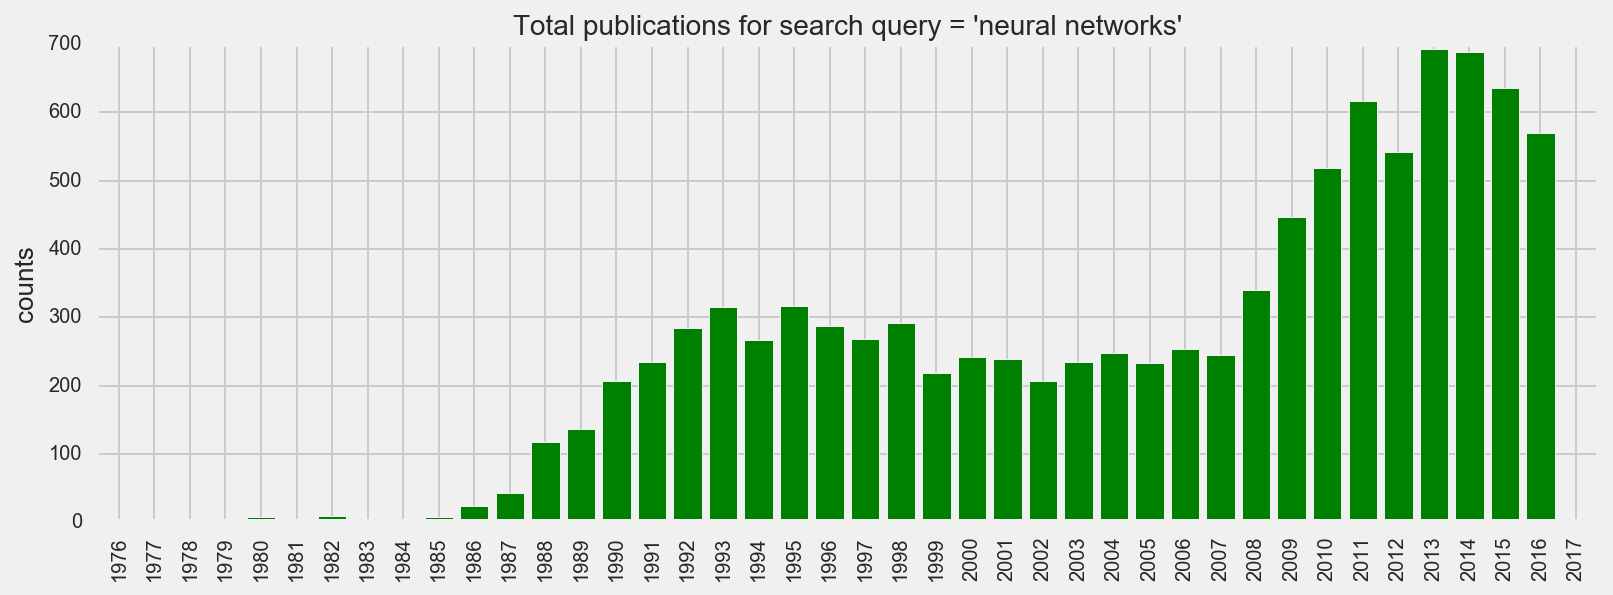

 
Running 50000 MCMC steps to estimate the expected number of publications per year
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec

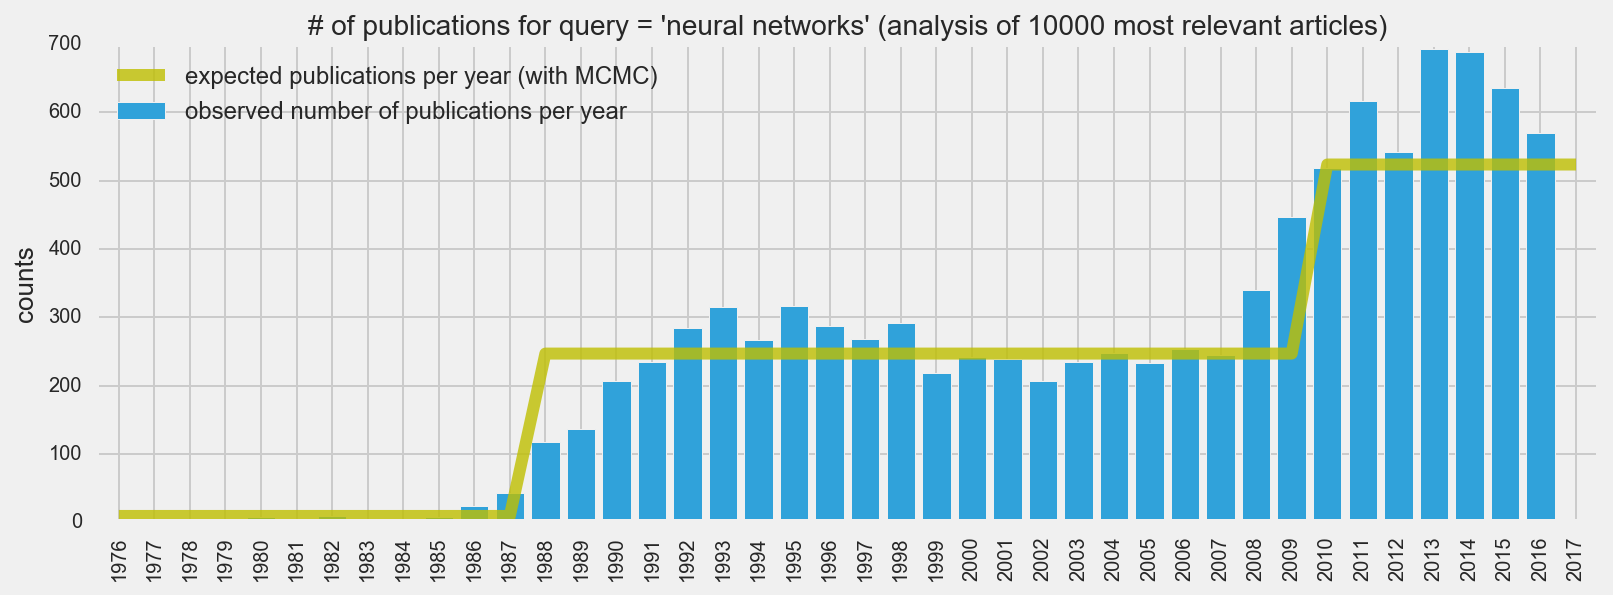


PRELIMINARY ANALYSIS of TEXT


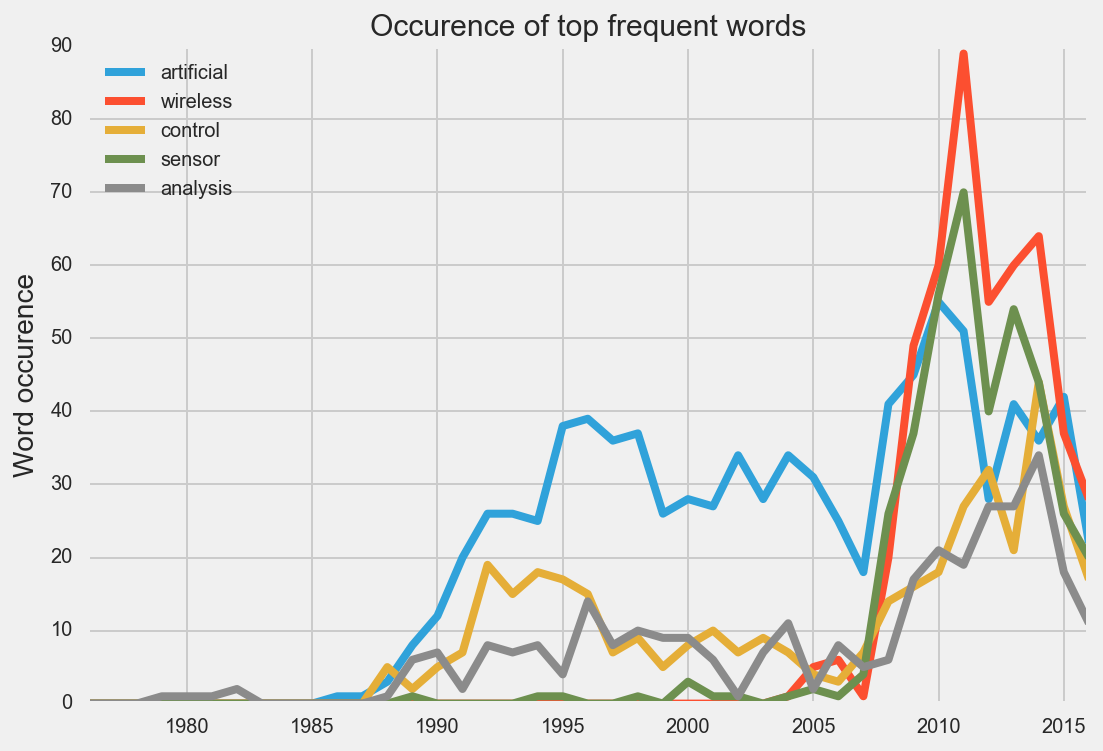


WORD CLOUD FOR YEARS BETWEEN 1976 and 1986


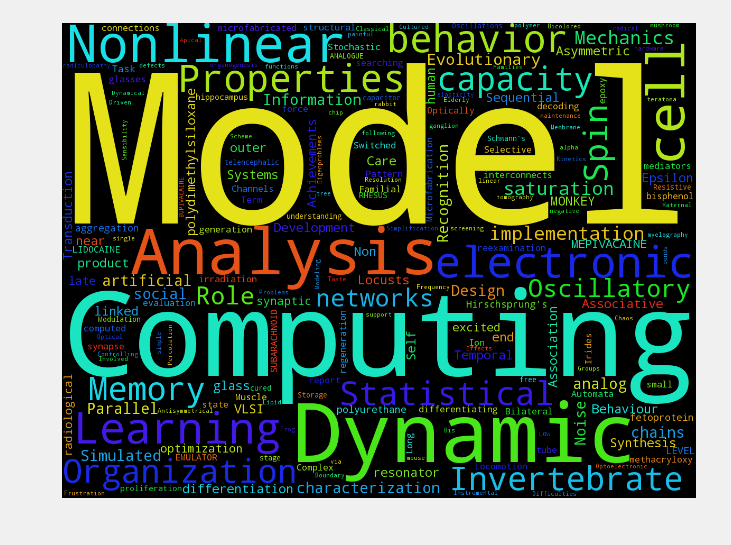


WORD CLOUD FOR YEARS BETWEEN 2006 and 2016


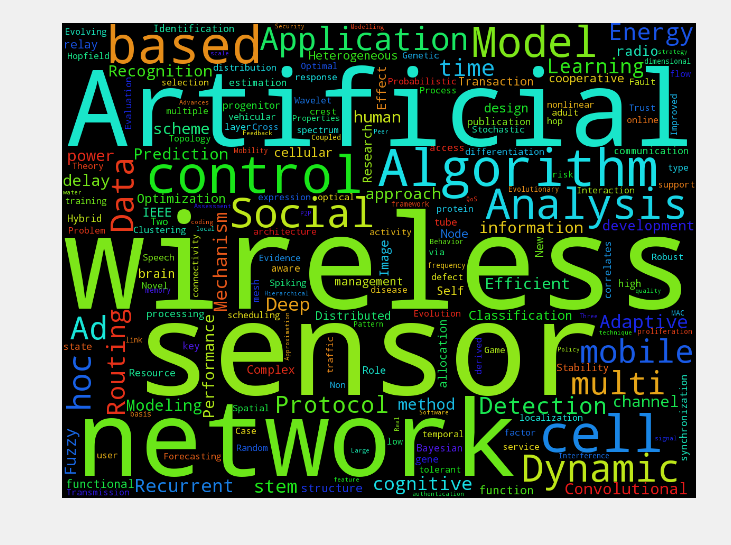

In [34]:
if __name__ == "__main__":
    df2, text2 = main(query='neural networks', years=40)